# Logistic regression

### Design matrix
Start with one predictor: stimulus

In [1]:
"""
IMPORTS
"""
import numpy as np
import numpy.random as npr
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# --Get my functions
functions_path = "../../Functions/"
os.chdir(functions_path)
from one_functions_generic import get_trials, performance_metrics, bin_frac, prepro

npr.seed(65)

In [2]:
"""
Load data
"""
trials_dir = '/home/ines/repositories/representation_learning_variability/DATA/'
#trials_dir = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
all_trials = pd.read_csv(trials_dir + "proficient_data.csv")  

From all data, focus on an example session of an example mouse 
Total of 530 trials should be enough for a sigmoid fit

In [3]:
mouse_example = all_trials.loc[(all_trials['subject_nickname']=='NYU-14') & (all_trials['session']=='63b4cbb9-25e6-453a-aa46-50c63613330c')]

In [4]:
mouse_example = prepro(mouse_example)

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:487: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['contrastLeft'] = trials['contrastLeft'].fillna(0)
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:488: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['contrastRight'] = trials['contrastRight'].fillna(0)
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:489: Se

Functions

In [5]:
def logistic(x, theta, intercept):
    # Logistic function (sigmoid)
    y = 1/(np.exp(-(x.dot(theta) + intercept))+1)
    return y


def initialize(dim, intercept=False):
    # Initialize theta array and bias 
    #b=random.random()
    #theta=np.random.rand(dim)
    if intercept == True:
        theta = np.random.randn(dim+1, 1) # adds one for the bias
    else:
        theta = np.random.randn(dim, 1)
    return theta


def loglikelihood(y, x, theta):
    ll = np.sum(y * np.log(logistic(x, theta)) + (1-y)* np.log(1-logistic(x, theta)))
    return ll


def gradient(x, y, theta_vector):
    # Computed gradient for Bernoulli distribution
    sigma = logistic(x, theta_vector)
    n = len(y)
    grad = (np.sum(sigma - y) * x )/ n
    grad = x *(sigma - y)
    grad = 2/n * x.T.dot(sigma - y)
    return grad
    
    
def gradient_descent(theta_dim, alpha, x, y, n_iter=50, tolerance=1e-06):
    # the algorithm will simultaneously update the theta values 
    # after each model fits to find the global minimum of our cost function.
    theta_vector = initialize(theta_dim, intercept=False)
    y_new = np.reshape(y, (len(y), 1))
    cost_lst = []
    thetas = []
    X_vector = np.c_[np.ones((len(x), 1)), x]  # Add intercept term to x
    X_vector = np.c_[x]  # no intercept term
    for i in range(n_iter):
        gradients = 1/len(y) * X_vector.T.dot(logistic(X_vector, theta_vector) - y_new)
        # Update theta
        theta_vector = theta_vector - alpha * gradients
        # Make predictions based on updated thetas
        y_pred = logistic(X_vector, theta_vector)
        
        #Calculate the loss for each training instance
        cost_value = - np.sum(np.dot(y_new.T, np.log(y_pred))+ 
                                   np.dot((1 - y_new).T, np.log(1 - y_pred))) / (len(y_pred))
        cost_lst.append(cost_value)
        thetas.append(theta_vector)
        # Decide when to stop and plot progress
        diff = -alpha * gradients
        if np.all(np.abs(diff) <= tolerance):
            plt.plot(np.arange(1, n_iter),cost_lst[1:], color = 'red')
            plt.title('Cost function Graph')
            plt.xlabel('Number of iterations')
            plt.ylabel('Cost')
            break

    return theta_vector, cost_lst, thetas

In [56]:
design_matrix = mouse_example[['signed_contrast', 'choice']]
design_matrix['past_choice'] = design_matrix['choice']
design_matrix['past_choice'][1:] = design_matrix['choice'][0:-1]

design_matrix = np.array(design_matrix[['signed_contrast', 'past_choice']])
design_matrix = design_matrix[1:]
design_matrix

/tmp/ipykernel_86174/2529974097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['past_choice'] = design_matrix['choice']
/tmp/ipykernel_86174/2529974097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['past_choice'][1:] = design_matrix['choice'][0:-1]


array([[-0.125, -1.   ],
       [ 1.   , -1.   ],
       [-0.125, -1.   ],
       ...,
       [-0.25 , -1.   ],
       [-1.   , -1.   ],
       [-0.25 , -1.   ]])

In [99]:
theta_dim = 2
alpha = 0.01
n_iter=10000
tolerance=1e-06
x = np.array(mouse_example[['signed_contrast', 'choice']])
x = np.array(mouse_example['signed_contrast'])
y = np.array(mouse_example['choice'])

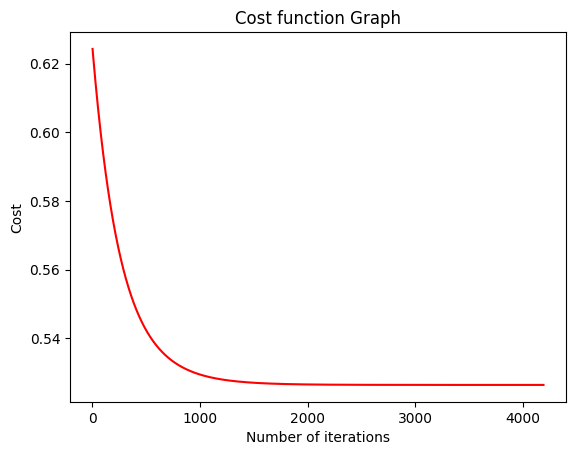

In [108]:
# the algorithm will simultaneously update the theta values 
# after each model fits to find the global minimum of our cost function.

# Transform original data for training
choice_mapping = {1: 0, -1: 1, 0: -1}
new_y = [choice_mapping[old_choice] for old_choice in y[1:]]
#new_y = [choice_mapping[old_choice] for old_choice in y]
y_true = np.reshape(new_y, (len(new_y), 1))
X_vector = np.c_[design_matrix]  # Add intercept term to x
#X_vector = np.c_[x]

# Initialize a parameters
theta_vector = initialize(theta_dim, intercept=False)
intercept = 0

# Initialize variables for keeping track of training
cost_lst = []
thetas = []
accuracies = []

for i in range(n_iter):
    #gradients = 1/len(y) * X_vector.T.dot(logistic(X_vector, theta_vector) - y_new)
    # Make predictions based on current thetas
    y_pred = logistic(X_vector, theta_vector, intercept)
    # Calculate gradient
    gradient_thetas = np.mean(X_vector.T.dot(y_pred - y_true))
    gradient_intercept = np.mean(y_pred - y_true)
    
    # Update theta (and intercept)
    theta_vector = theta_vector - alpha * gradient_thetas
    intercept = intercept - alpha * gradient_intercept
    # Calculate accuracy
    choice_pred = [1 if p > 0.5 else 0 for p in y_pred]  # this does not make sense... should throw a coin and then 
    #TODO: need to make this without loop
    #choice_pred = np.zeros(len(y_pred)) * np.nan
    #for p, prob in enumerate(range(len(y_pred))):
    #    if random.random() < y_pred[p]:
    #        choice_pred[p] = 0
    #    else:
    #        choice_pred[p] = 1
    accuracy = accuracy_score(y_true, choice_pred)
    
    #Calculate the loss for each training instance
    cost_value = - np.sum(np.dot(y_true.T, np.log(y_pred))+ 
                                np.dot((1 - y_true).T, np.log(1 - y_pred))) / (len(y_pred))
    
    # Save values 
    cost_lst.append(cost_value)
    thetas.append(theta_vector)
    accuracies.append(accuracy)
    
    # Decide when to stop and plot progress
    diff = -alpha * gradient_thetas
    if np.all(np.abs(diff) <= tolerance):
        plt.plot(np.arange(1, i+1),cost_lst[1:], color = 'red')
        plt.title('Cost function Graph')
        plt.xlabel('Number of iterations')
        plt.ylabel('Cost')
        break


Text(0, 0.5, 'Theta')

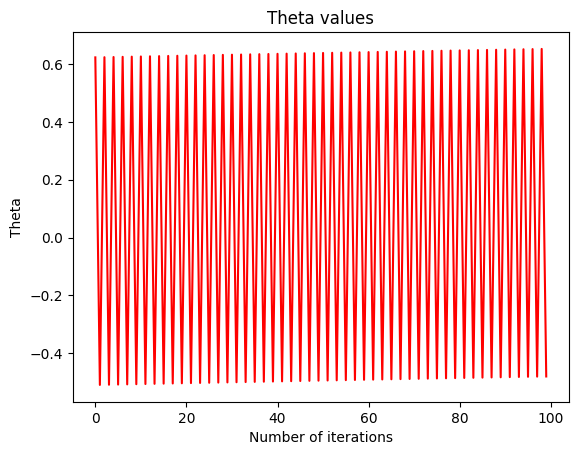

In [92]:
plt.plot(np.arange(0, len(thetas)), np.reshape(thetas, (2, len(thetas)))[1:][0], color = 'red')
plt.title('Theta values')
plt.xlabel('Number of iterations')
plt.ylabel('Theta')

In [75]:
plt.plot(np.arange(1, len(thetas)),np.reshape(thetas, (len(thetas)))[1:], color = 'red')
plt.title('Theta values')
plt.xlabel('Number of iterations')
plt.ylabel('Theta')

ValueError: cannot reshape array of size 200 into shape (100,)

Text(0, 0.5, 'Accuracy')

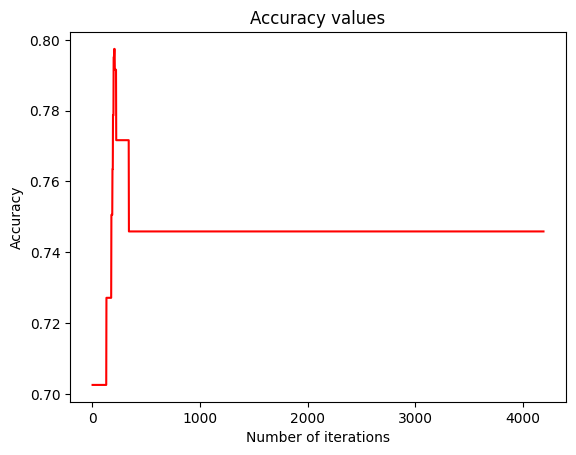

In [109]:
plt.plot(np.arange(1, len(accuracies)),np.reshape(accuracies, (len(accuracies)))[1:], color = 'red')
plt.title('Accuracy values')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')

In [83]:

x_data = mouse_example[['signed_contrast', 'choice']]
x_data['past_choice'] = x_data['choice']
x_data['past_choice'][1:] = x_data['choice'][0:-1]

x_data = np.array(x_data[['signed_contrast', 'past_choice']])
x_data = x_data[1:]

y_data = np.array(mouse_example['choice'])
y_data = [choice_mapping[old_choice] for old_choice in y_data]

x_avg = np.unique(x_data)
y_avg = np.zeros(len(x_avg)) * np.nan
for s, stim in enumerate(x_avg):
    y_avg[s] = np.mean(np.array(y_data)[np.where(x_data==stim)[0]])

/tmp/ipykernel_86174/905048441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data['past_choice'] = x_data['choice']
/tmp/ipykernel_86174/905048441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_data['past_choice'][1:] = x_data['choice'][0:-1]


In [84]:
x_vector = np.arange(-1, 1, 0.01)
x_model = np.c_[x_vector] 
#theta_learned = np.reshape(thetas, (len(thetas)))[-1]
theta_learned = thetas[-1]
y_model = logistic(x_model, theta_learned, intercept)

x_avg_model = np.unique(x_model)
y_avg_model = np.zeros(len(x_avg_model)) * np.nan
for s, stim in enumerate(x_avg_model):
    y_avg_model[s] = np.mean(np.array(y_model)[np.where(x_vector==stim)[0]])

ValueError: shapes (200,1) and (2,1) not aligned: 1 (dim 1) != 2 (dim 0)

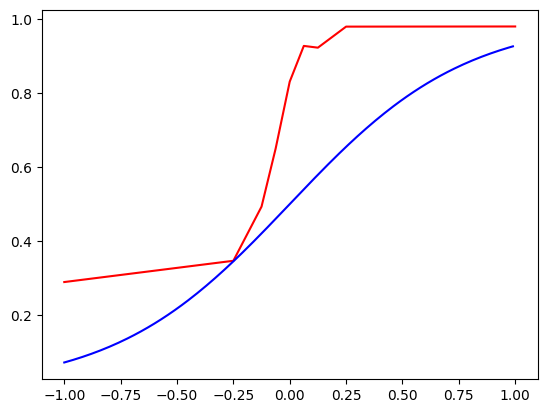

In [48]:
plt.plot(x_avg, y_avg, color='red', label='Data')
plt.plot(x_avg_model, y_avg_model, color='blue', label='Model')

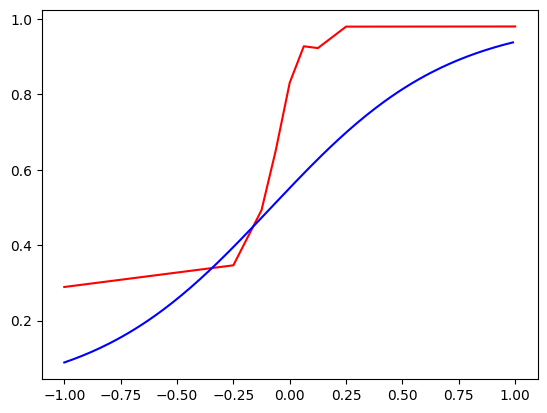

In [54]:
plt.plot(x_avg, y_avg, color='red', label='Data')
plt.plot(x_avg_model, y_avg_model, color='blue', label='Model')